In [1]:
!pip install --upgrade openai --quiet


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 328.4/328.4 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 3.2 MB/s eta 0:00:00


In [14]:
from google.colab import userdata
OPEN_AI_KEY=userdata.get('opeaikey4o')
from openai import OpenAI

In [15]:
## Set the API key and model name
MODEL="gpt-3.5-turbo"
client = OpenAI(api_key=OPEN_AI_KEY)

In [16]:
import json
import openai
import os
import pandas as pd
from pprint import pprint
import time
import matplotlib.pyplot as plt

## Read in the dataset we'll use for this task.
## This will be the RecipesNLG dataset, which we've cleaned to only contain documents from www.cookbooks.com

In [17]:
qa_df=pd.read_csv('olympics_qa_lg.csv')
qa_df.head()

,title,heading,content,tokens,context,questions,answers
0,2020 Summer Olympics,Summary,"The 2020 Summer Olympics, officially the Games...",623,2020 Summer Olympics\nSummary\n\nThe 2020 Summ...,What were some of the new events introduced in...,Some of the new events introduced in existing ...
1,2016 Winter Youth Olympics,Summary,The 2016 Winter Youth Olympics (Norwegian: Oly...,152,2016 Winter Youth Olympics\nSummary\n\nThe 201...,What was significant about the 2016 Winter You...,The 2016 Winter Youth Olympics held in Lilleha...
2,2016 Winter Youth Olympics,Host selection,Lillehammer was the only city to bid for the g...,129,2016 Winter Youth Olympics\nHost selection\n\n...,What was the process for selecting the host ci...,The process for selecting the host city for th...
3,Olympic Games ceremony,Summary,The Olympic Games ceremonies of the Ancient Ol...,271,Olympic Games ceremony\nSummary\n\nThe Olympic...,What are some elements of the modern Olympic G...,Some elements of the modern Olympic Games cere...
4,Olympic Games ceremony,Ancient forerunners,"The Ancient Games, held in Greece from ca. 776...",247,Olympic Games ceremony\nAncient forerunners\n\...,What were some of the elements involved in the...,Some of the elements involved in the victory c...


#Data preparation


In [34]:
training_data=[]
system_message="You are a helpful wikipedia assitant. You have extract the answer each of the context and questions provided"

In [50]:
def create_user_message(row):
  return f"Question:{row['questions']}\n\Context:{row['context']}\n\nGeneric ingredients:"


def prepare_example_conversation(row):
  messages=[]
  messages.append({"role":"system","content":system_message})

  user_message=create_user_message(row)
  messages.append({"role":"user","content":user_message})

  messages.append({"role":"assistant","content":row["answers"]})

  return {"messages":messages}

pprint(prepare_example_conversation(qa_df.iloc[0]))

{'messages': [{'content': 'You are a helpful wikipedia assitant. You have '
                          'extract the answer each of the context and '
                          'questions provided',
               'role': 'system'},
              {'content': 'Question:What were some of the new events '
                          'introduced in existing sports at the 2020 Summer '
                          'Olympics in Tokyo?\n'
                          '\\Context:2020 Summer Olympics\n'
                          'Summary\n'
                          '\n'
                          'The 2020 Summer Olympics, officially the Games of '
                          'the XXXII Olympiad and officially branded as Tokyo '
                          '2020, were an international multi-sport event held '
                          'from 23 July to 8 August 2021 in Tokyo, Japan, with '
                          'some preliminary events that began on 21 July 2021. '
                          'Tokyo was sele

Note:In last assitant is the outuput data

Let's now do this for a subset of the dataset to use as our training data. You can begin with even 30-50 well-pruned examples. You should see performance continue to scale linearly as you increase the size of the training set, but your jobs will also take longer.

## use the first 100 rows of the dataset for training


In [36]:
len(qa_df)

759

In [51]:
training_df=qa_df.iloc[:100]


### apply the prepare_example_conversation function to each row of the training_df


In [52]:
trainig_data=training_df.apply(prepare_example_conversation,axis=1).tolist()

for example in trainig_data[:5]:
  print(example)

{'messages': [{'role': 'system', 'content': 'You are a helpful wikipedia assitant. You have extract the answer each of the context and questions provided'}, {'role': 'user', 'content': 'Question:What were some of the new events introduced in existing sports at the 2020 Summer Olympics in Tokyo?\n\\Context:2020 Summer Olympics\nSummary\n\nThe 2020 Summer Olympics, officially the Games of the XXXII Olympiad and officially branded as Tokyo 2020, were an international multi-sport event held from 23 July to 8 August 2021 in Tokyo, Japan, with some preliminary events that began on 21 July 2021. Tokyo was selected as the host city during the 125th IOC Session in Buenos Aires, Argentina on 7 September 2013.\nOriginally scheduled to take place from 24 July to 9 August 2020, the event was postponed to 2021 on 24 March 2020 due to the global COVID-19 pandemic, the first such instance in the history of the Olympic Games (previous games had been cancelled but not rescheduled). However, the event re

### optionally provide validation data,

In [53]:
validation_df=qa_df.iloc[101:200]

validation_data=validation_df.apply(prepare_example_conversation,axis=1).tolist()

### We then need to save our data as .jsonl files, with each line being one training example conversation.



In [54]:
def write_jsonl(data_list:list,filename:str):
  with open(filename,"w") as out:
    for data in data_list:
      jout=json.dumps(data)+"\n"
      out.write(jout)



In [55]:
training_file_name="qa_fine_tune_training.jsonl"
write_jsonl(trainig_data,training_file_name)

validation_file_name="qa_fine_tune_validation.jsonl"
write_jsonl(validation_data,validation_file_name)

#### print the first 5 lines of the training file

In [56]:
!head -n 5 qa_fine_tune_training.jsonl

{"messages": [{"role": "system", "content": "You are a helpful wikipedia assitant. You have extract the answer each of the context and questions provided"}, {"role": "user", "content": "Question:What were some of the new events introduced in existing sports at the 2020 Summer Olympics in Tokyo?\n\\Context:2020 Summer Olympics\nSummary\n\nThe 2020 Summer Olympics, officially the Games of the XXXII Olympiad and officially branded as Tokyo 2020, were an international multi-sport event held from 23 July to 8 August 2021 in Tokyo, Japan, with some preliminary events that began on 21 July 2021. Tokyo was selected as the host city during the 125th IOC Session in Buenos Aires, Argentina on 7 September 2013.\nOriginally scheduled to take place from 24 July to 9 August 2020, the event was postponed to 2021 on 24 March 2020 due to the global COVID-19 pandemic, the first such instance in the history of the Olympic Games (previous games had been cancelled but not rescheduled). However, the event re

#Upload files
You can now upload the files to our Files endpoint to be used by the fine-tuned model.



In [57]:
with open(training_file_name,"rb") as training_fd:
  training_response=client.files.create(
      file=training_fd,
      purpose="fine-tune"
  )

training_file_id=training_response.id



In [58]:
with open(validation_file_name,"rb") as validation_fd:
  validation_response=client.files.create(
      file=validation_fd,
      purpose="fine-tune"
  )

validation_file_id=validation_response.id

In [59]:
print("Training file Id: ",training_file_id)
print("Validation file Id: ",validation_file_id)

Training file Id:  file-tDMAWBCSnM4NVGsSGGHrAk9P
Validation file Id:  file-QKODNqAZAHjI5tdJcB9n7EEq


#Fine-tuning


fine_tunning_job_auto=client.fine_tuning.jobs.create(
    training_file=data_file.id,
    model='gpt-3.5-turbo',
    hyperparameters={
        "n_epochs":'auto'
    }
)

In [60]:
response=client.fine_tuning.jobs.create(
    training_file=training_file_id,
    validation_file=validation_file_id,
    model=MODEL
)

In [61]:
job_id=response.id
print("Job Id",job_id)
print("Status",response.status)

Job Id ftjob-KcwY8JXiWf8Bq0vDp5eph8Uh
Status validating_files


# Check job status
You can make a GET request to the https://api.openai.com/v1/alpha/fine-tunes endpoint to list your alpha fine-tune jobs. In this instance you'll want to check that the ID you got from the previous step ends up as status: succeeded.

In [62]:
response=client.fine_tuning.jobs.retrieve(job_id)
print("Job Id",response.id)
print("Status",response.status)
print("Trained Token:",response.trained_tokens)

Job Id ftjob-KcwY8JXiWf8Bq0vDp5eph8Uh
Status validating_files
Trained Token: None


In [63]:
while True:
  time.sleep(5)
  retrieved_jobs_auto=client.fine_tuning.jobs.retrieve(job_id)
  status=retrieved_jobs_auto.status
  print(status)
  if(status=='succeeded'):
    print("Job Id",response.id)
    print("Status",response.status)
    print("Trained Token:",response.trained_tokens)
    break

running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running
running


We can track the progress of the fine-tune with the events endpoint. You can rerun the cell below a few times until the fine-tune is ready.



In [64]:
response=client.fine_tuning.jobs.list_events(job_id)
events=response.data
events.reverse()

for event in events:
  print(event)

FineTuningJobEvent(id='ftevent-ZcYgpItHFmvRjUKEZqpOsX36', created_at=1720549654, level='info', message='Step 285/300: training loss=0.16', object='fine_tuning.job.event', data={'step': 285, 'train_loss': 0.16073399782180786, 'total_steps': 300, 'train_mean_token_accuracy': 0.9354838728904724}, type='metrics')
FineTuningJobEvent(id='ftevent-vxZr1jCUdBn7YqOxcCVavkYF', created_at=1720549656, level='info', message='Step 286/300: training loss=0.06', object='fine_tuning.job.event', data={'step': 286, 'train_loss': 0.061877619475126266, 'total_steps': 300, 'train_mean_token_accuracy': 0.9795918464660645}, type='metrics')
FineTuningJobEvent(id='ftevent-108rIIAmDyH1lvjmxfl5AybN', created_at=1720549658, level='info', message='Step 287/300: training loss=0.07', object='fine_tuning.job.event', data={'step': 287, 'train_loss': 0.06549014896154404, 'total_steps': 300, 'train_mean_token_accuracy': 0.9736841917037964}, type='metrics')
FineTuningJobEvent(id='ftevent-4HYKl4yrkRcyqHyZ1VWTS5hR', created_

In [65]:
steps=[]
train_loss=[]
for e in events:
  if(e.data):
    steps.append(e.data['step'])
    train_loss.append(e.data['train_loss'])
print(steps)
print(train_loss)

[285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299, 300]
[0.16073399782180786, 0.061877619475126266, 0.06549014896154404, 0.018343111500144005, 3.137896101179649e-06, 0.0036470189224928617, 2.5353780074510723e-05, 0.00048645338392816484, 0.06136584281921387, 0.01236635074019432, 0.03151745721697807, 1.5979343515937217e-05, 0.15181651711463928, 0.00024598330492153764, 0.04907325655221939, 0.14133749902248383]


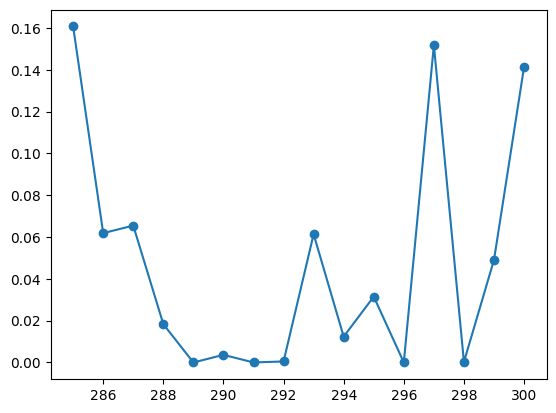

In [66]:
plt.plot(steps,train_loss,marker='o',linestyle='-')

In [67]:
response = client.fine_tuning.jobs.retrieve(job_id)
fine_tuned_model_id = response.fine_tuned_model

if fine_tuned_model_id is None:
    raise RuntimeError("Fine-tuned model ID not found. Your job has likely not been completed yet.")

print("Fine-tuned model ID:", fine_tuned_model_id)

Fine-tuned model ID: ft:gpt-3.5-turbo-0125:personal::9j9rXKRz


# Inference
The last step is to use your fine-tuned model for inference. Similar to the classic FineTuning, you simply call ChatCompletions with your new fine-tuned model name filling the model parameter.



In [68]:
test_df=qa_df[201:300]
test_row=test_df.iloc[0]
test_messages=[]

test_messages.append({"role":"system", "content":system_message})
user_messages=create_user_message(test_row)
test_messages.append({"role":"user", "content":user_messages})

pprint(test_messages)


[{'content': 'You are a helpful wikipedia assitant. You have extract the '
             'answer each of the context and questions provided',
  'role': 'system'},
 {'content': 'Question:**Question:** How many divers advance from the '
             "preliminary round to the semi-final in the Men's 3 metre "
             'springboard diving event at the 2016 Summer Olympics?\n'
             "\\Context:Diving at the 2016 Summer Olympics – Men's 3 metre "
             'springboard\n'
             'Format\n'
             '\n'
             'The competition was held in three rounds:\n'
             '\n'
             'Preliminary round: All 29 divers perform six dives; the top 18 '
             'divers advance to the semi-final.\n'
             'Semi-final: The 18 divers perform six dives; the scores of the '
             'qualifications are erased and the top 12 divers advance to the '
             'final.\n'
             'Final: The 12 divers perform six dives; the semi-final scores '
       

In [69]:
response=client.chat.completions.create(
    model=fine_tuned_model_id,
    messages=test_messages,
    temperature=0,
    max_tokens=500
)

print(response.choices[0].message.content)

18 divers advance from the preliminary round to the semi-final in the Men's 3 metre springboard diving event at the 2016 Summer Olympics.


# custom message for context

In [70]:
system_message="You are a helpful wikipedia assitant. You have to give  the answer of  each question user has asked"

In [80]:
def create_custom_user_message(question):
  return f"Question:{question}\n\n"


In [81]:
question="Where does the Olympic games take place 2016?"

In [82]:
test_messages=[]

test_messages.append({"role":"system", "content":system_message})
user_messages=create_custom_user_message(question)
test_messages.append({"role":"user", "content":user_messages})

pprint(test_messages)

[{'content': 'You are a helpful wikipedia assitant. You have to give  the '
             'answer of  each question user has asked',
  'role': 'system'},
 {'content': 'Question:Where does the Olympic games take place 2016?\n\n',
  'role': 'user'}]


In [83]:
response=client.chat.completions.create(
    model=fine_tuned_model_id,
    messages=test_messages,
    temperature=0,
    max_tokens=500
)

print(response.choices[0].message.content)

The 2016 Summer Olympic Games took place in Rio de Janeiro, Brazil.
